In [1]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.image as mpimg
from PIL import Image
from skimage import img_as_ubyte

In [2]:
def double_conv(in_channels, out_channels):

    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 2, dilation=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 2, dilation=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True)
    )

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        
        self.dconv_d1 = double_conv(1, 64)
        self.dconv_d2 = double_conv(64, 128)
        self.dconv_d3 = double_conv(128, 256)
        self.dconv_d4 = double_conv(256, 512)
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.dconv_u3 = double_conv(512 + 256, 256) # skip connection, so adding 256
        self.dconv_u2 = double_conv(256 + 128, 128)
        self.dconv_u1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, 1, 1, dilation=1)
        
    def forward(self, x):
        conv1 = self.dconv_d1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.dconv_d2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_d3(x)
        x = self.maxpool(conv3)
        
        x = self.dconv_d4(x)
        
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim = 1)
        
        x = self.dconv_u3(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_u2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_u1(x)
        
        out = self.conv_last(x)
        
        return out

In [3]:
def double_conv(in_channels, out_channels):

    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True)
    )

def conv(in_channels, out_channels):

    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),
    )

class UNet_tail(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        
        self.dconv_d1 = double_conv(1, 64)
        self.dconv_d2 = double_conv(64, 128)
        self.dconv_d3 = double_conv(128, 256)
        self.dconv_d4 = double_conv(256, 512)
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.dconv_u3 = double_conv(512 + 256, 256) # skip connection, so adding 256
        self.dconv_u2 = double_conv(256 + 128, 128)
        self.dconv_u1 = double_conv(128 + 64, 64)
        
        self.conv1 = conv(64, 64)
        self.conv2 = conv(64, 64)
        self.conv3 = conv(64, 64)
        
        self.conv_last = nn.Conv2d(64, 1, 1)
        
    def forward(self, x):
        conv1 = self.dconv_d1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.dconv_d2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_d3(x)
        x = self.maxpool(conv3)
        
        x = self.dconv_d4(x)
        
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim = 1)
        
        x = self.dconv_u3(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_u2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_u1(x)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        out = self.conv_last(x)
        
        return out

In [4]:
def get_centres(img, get_areas=False):
    #try:
    img = np.uint8(img)
    #except:
    #    img = img
    ret, thresh = cv2.threshold(img, 0.001, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    centres = []
    if get_areas:
        areas = []
    for c in contours:
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centres.append([cX, cY])
            if get_areas:
                area = cv2.contourArea(c)
                areas.append(area)


    centres = np.array(centres)
    if get_areas:
        return centres, np.array(areas)
    else:
        return centres

In [5]:
def get_centres_null(img, get_areas=False):
    ret,thresh = cv2.threshold(img, 0.001, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    centres = []
    if get_areas:
        areas = [] 
    for c in contours:
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            pass
        centres.append([cX, cY])
        if get_areas:
            area = cv2.contourArea(c)
            areas.append(area)
    centres = np.array(centres)
    if get_areas:
        return centres, np.array(areas)
    else:
        return centres

In [6]:
def precision_recall(y_true, y_pred):
    SMOOTH = 1e-6
    
    centres = get_centres(y_true)
    centres_pred = get_centres(y_pred)

    tp = 0
    fn = 0
    fp = 0
    
    if len(centres) > 0:
        for x, y in zip(centres[:,0], centres[:,1]):
            if y_pred[y,x] > 0:
                tp += 1
            else:
                fn += 1
    
        if len(centres_pred) > 0:
            for x, y in zip(centres_pred[:,0], centres_pred[:,1]):
                if y_true[y,x] == 0:
                    fp += 1
    

        precision = tp / (tp + fp + SMOOTH)
        recall = tp / (tp + fn + SMOOTH)
    
    else:
        precision = 0
        recall = 0

    return precision, recall

In [7]:
def mAcc(y_true, y_pred):
    intersection_pos = (y_pred.astype(bool) & y_true.astype(bool)).astype(float).sum()
    intersection_neg = (np.invert(y_pred.astype(bool)) & np.invert(y_true.astype(bool))).astype(float).sum()
    num_pixels = msk.shape[0] * msk.shape[1]
    
    mAcc = (intersection_pos + intersection_neg) / (num_pixels)
    return mAcc

def mIoU(y_true, y_pred):
    SMOOTH = 1e-6
    
    intersection_pos = (y_pred.astype(bool) & y_true.astype(bool)).astype(float).sum()
    union_pos = (y_pred.astype(bool) | y_true.astype(bool)).astype(float).sum()
    
    intersection_neg = (np.invert(y_pred.astype(bool)) & np.invert(y_true.astype(bool))).astype(float).sum()
    union_neg = (np.invert(y_pred.astype(bool)) | np.invert(y_true.astype(bool))).astype(float).sum()
    
    iou_pos = (intersection_pos.sum() + SMOOTH) / (union_pos.sum() + SMOOTH)
    iou_neg = (intersection_neg.sum() + SMOOTH) / (union_neg.sum() + SMOOTH)
    
    mIoU = (iou_pos + iou_neg) / 2
    return mIoU

In [8]:
def make_bins(areas, bin_size):
    sizes, counts = [], []
    for i, a in enumerate(range(int(np.floor(np.min(areas))), int(np.ceil(np.max(areas))), bin_size)):
        if i == 0:
            prev = a
            continue
        else:
            sizes.append(np.mean([prev, a]))
            count = 0
            for area in areas:
                if prev <= area < a:
                    count += 1
            prev = a
            counts.append(count)
    # for last bin
    sizes
    count = 0
    for area in areas:
        if a <= area < np.max(areas) + 1:
            count += 1
    sizes.append(np.max(areas))
    counts.append(count)
    
    return sizes, counts

In [9]:
def plot_FSD(size, count, ax, color='b', data_type='Data Points'):
    empty_inds = []
    for i, c in enumerate(count):
        if c == 0:
            empty_inds.append(i)
    for index in sorted(empty_inds, reverse=True):
        del size[index]
        del count[index]
    ax.scatter(size, count, c=color, marker='x', label=data_type)
    ax.set_xlabel('Floe Area (pixels)')
    ax.set_ylabel('Frequency')
    ax.set_ylim([0, None])

In [10]:
def get_areas_validation(image_path, mask_path, model_path):
    areas_mask_final, areas_pred_final = [], []
    
    file = torch.load(model_path)
    model = UNet(1)
    model.load_state_dict(file['model_state_dict'])
    model.cuda()
    model.eval();
    
    images = os.listdir(image_path)
    masks = os.listdir(mask_path)
    for i in range(len(images)):
        print('Processing Image: {}'.format(images[i]))
        image = os.path.join(image_path + images[i])
        mask = os.path.join(mask_path + masks[i])
        
        if '.png' in image:
            img = mpimg.imread(image)
            img = img * 255
        else:
            img = Image.open(image)
            img = np.array(img)
            img = img * 255
            img = img_as_ubyte(img)

        if '.png' in mask:
            m = cv2.imread(mask)
            msk = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
        else:
            msk = Image.open(mask)
            msk = np.array(msk)
            msk = img_as_ubyte(msk)
        
        X = TF.to_tensor(img).unsqueeze(1).cuda()
        pred = model(X)
        pred_thresh = (pred[0, 0, :, :].cpu().detach().numpy() > 0).astype(np.uint8)
        print(np.max(pred_thresh))
        
        _, areas_mask = get_centres(msk, get_areas=True)
        _, areas_pred = get_centres(pred_thresh, get_areas=True)
        
        areas_mask_final += list(areas_mask)
        areas_pred_final += list(areas_pred)
        
    return areas_mask_final, areas_pred_final

        

In [19]:
image_path = '../parsing/U-Net/validation_small/image_patches/'
mask_path = '../parsing/U-Net/validation_small/mask_patches/'
model_path = '../models/test_39928it_96size_lr10e-2.model'

In [20]:
file = torch.load(model_path)
model = UNet(1)
model.load_state_dict(file['model_state_dict'])
model.cuda()
model.eval()

images = os.listdir(image_path)
masks = os.listdir(mask_path)

In [21]:
i = 0
image = os.path.join(image_path + images[i])
mask = os.path.join(mask_path + masks[i])

img = mpimg.imread(image)
img = img * 255

m = cv2.imread(mask)
msk = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)

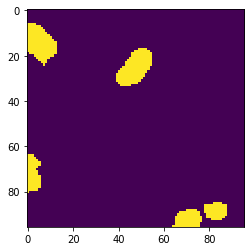

In [22]:
plt.imshow(msk)

In [23]:
X = TF.to_tensor(img).unsqueeze(1).cuda()
print(X)

tensor([[[[ 72., 120., 201.,  ..., 231., 216., 217.],
          [ 55.,  72., 148.,  ..., 220., 218., 180.],
          [169., 106.,  55.,  ..., 238., 217., 202.],
          ...,
          [ 29.,  49.,  16.,  ...,  88.,  88.,  83.],
          [ 49.,  33.,  38.,  ...,  83.,  78.,  78.],
          [ 83.,  93.,  38.,  ...,  83.,  78.,  66.]]]], device='cuda:0')


In [24]:
model.eval()
pred = model(X)
print(pred)

tensor([[[[-10.4302,  -9.6035,  -9.1957,  ..., -15.0150, -13.9502, -13.2169],
          [ -9.4721,  -9.0854,  -8.1513,  ..., -15.4726, -14.1736, -14.1529],
          [ -8.9579,  -8.7964,  -8.4052,  ..., -14.6261, -14.0710, -13.8306],
          ...,
          [-12.4329, -13.6847, -15.1568,  ..., -10.5400, -10.0154, -11.2249],
          [-12.2482, -12.9571, -13.6134,  ..., -10.4931, -10.4387, -11.7932],
          [-13.2714, -13.4000, -14.1161,  ..., -11.9642, -11.9537, -12.8141]]]],
       device='cuda:0', grad_fn=<CudnnConvolutionBackward>)


In [25]:
X = TF.to_tensor(img).unsqueeze(1).cuda()
pred = model(X)
pred_thresh = (pred[0, 0, :, :].cpu().detach().numpy() > 0)

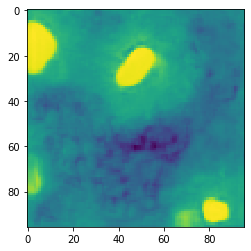

In [26]:
plt.imshow(pred[0, 0, :, :].cpu().detach().numpy())

In [27]:
image_path = '../parsing/U-Net/validation_small/image_patches/'
mask_path = '../parsing/U-Net/validation_small/mask_patches/'
model_path = '../models/test_39928it_96size_lr10e-2.model'
areas_mask_final, areas_pred_final = get_areas_validation(image_path, mask_path, model_path)

Processing Image: im_rsat2_ar_20110615105638_00079057_l1001.png
1
Processing Image: im_rsat2_ar_20110615105638_00079057_l1019.png
1
Processing Image: im_rsat2_ar_20110615105638_00079057_l1054.png
1
Processing Image: im_rsat2_ar_20110615105638_00079057_l1071.png
0
Processing Image: im_rsat2_ar_20110615105638_00079057_l1072.png
1
Processing Image: im_rsat2_ar_20110615105638_00079057_l1086.png
1
Processing Image: im_rsat2_ar_20110615105638_00079057_l1087.png
1
Processing Image: im_rsat2_ar_20110615105638_00079057_l1094.png
0
Processing Image: im_rsat2_ar_20110615105638_00079057_l1102.png
1
Processing Image: im_rsat2_ar_20110615105638_00079057_l1141.png
0
Processing Image: im_rsat2_ar_20110615105638_00079057_l1146.png
1
Processing Image: im_rsat2_ar_20110615105638_00079057_l1153.png
1
Processing Image: im_rsat2_ar_20110615105638_00079057_l1168.png
1
Processing Image: im_rsat2_ar_20110615105638_00079057_l1173.png
1
Processing Image: im_rsat2_ar_20110615105638_00079057_l1174.png
0
Processing

In [28]:
len(areas_mask_final)

954

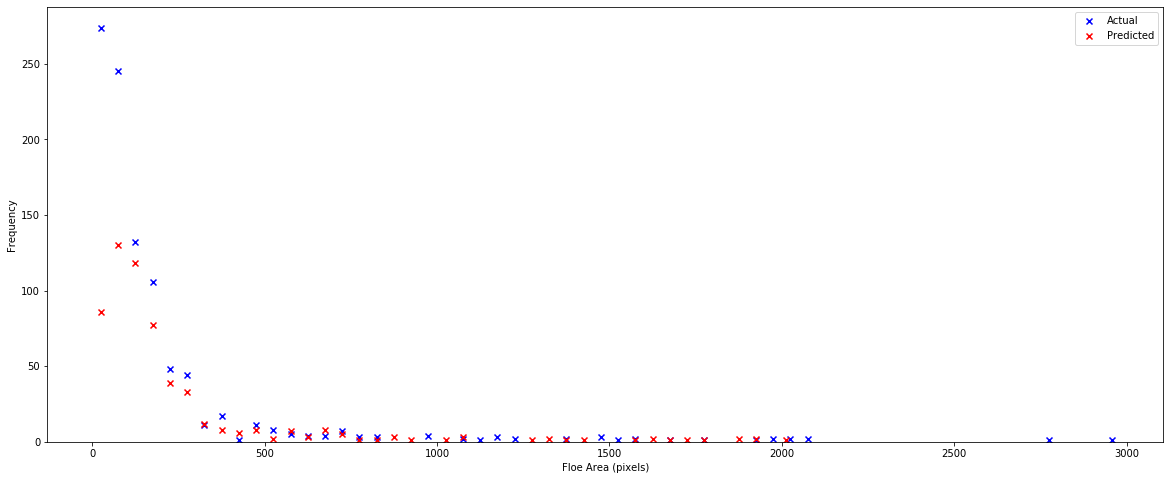

In [29]:
bin_size = 50
bins_x_mask, bins_y_mask = make_bins(areas_mask_final, bin_size)
bins_x_pred, bins_y_pred = make_bins(areas_pred_final, bin_size)
fig, ax = plt.subplots(figsize=(20,8))
plot_FSD(bins_x_mask, bins_y_mask, ax, data_type='Actual')
plot_FSD(bins_x_pred, bins_y_pred, ax, color='r', data_type='Predicted')
plt.legend()
plt.show()

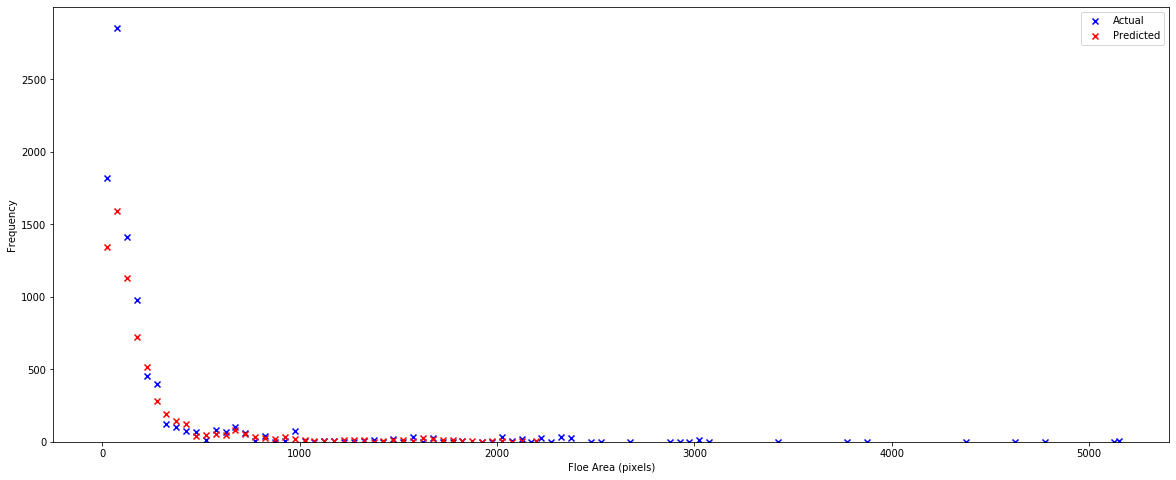

In [28]:
bin_size = 50
bins_x_mask, bins_y_mask = make_bins(areas_mask_final, bin_size)
bins_x_pred, bins_y_pred = make_bins(areas_pred_final, bin_size)
fig, ax = plt.subplots(figsize=(20,8))
plot_FSD(bins_x_mask, bins_y_mask, ax, data_type='Actual')
plot_FSD(bins_x_pred, bins_y_pred, ax, color='r', data_type='Predicted')
plt.legend()
plt.show()

In [22]:
file = torch.load('../models/test_39928it_96size_lr10e-2.model')
model = UNet(1)
model.load_state_dict(file['model_state_dict'])
model.cuda()
model.eval();

In [10]:
X = TF.to_tensor(img).unsqueeze(1).cuda()
pred = model(X)
pred_thresh = (pred[0, 0, :, :].cpu().detach().numpy() > 0).astype(np.uint8)

Precision: 1.000, Recall: 0.750
Mean Pixel Accuracy: 0.996
Mean IoU: 0.873


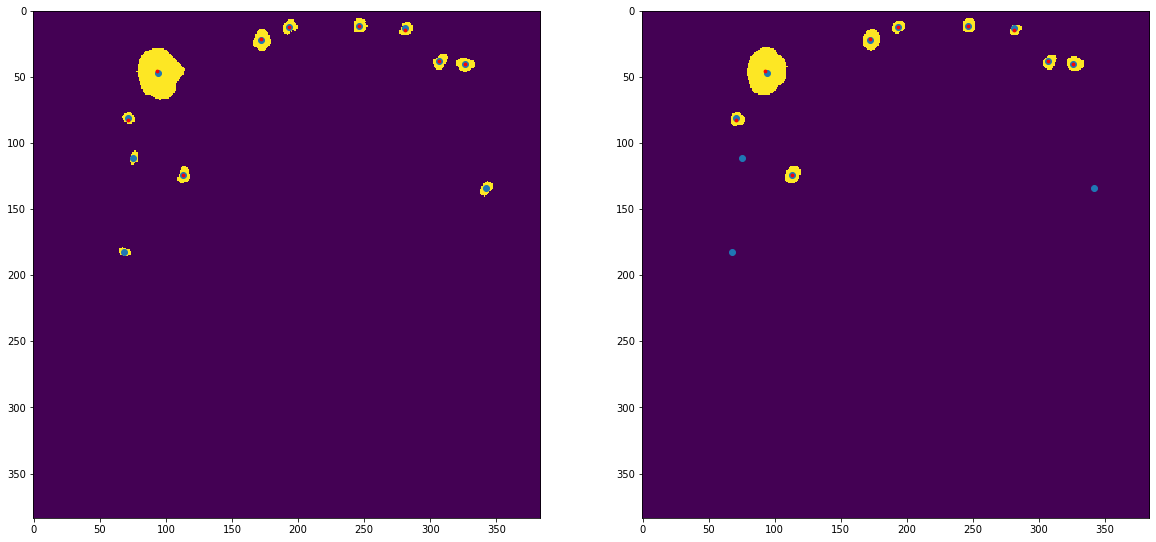

In [11]:
centres = get_centres(msk)
centres_pred = get_centres(pred_thresh)

pre, rec = precision_recall(msk, pred_thresh)
mAcc = mAcc(msk, pred_thresh)
mIoU = mIoU(msk, pred_thresh)
print('Precision: {:.3f}, Recall: {:.3f}'.format(pre, rec))
print('Mean Pixel Accuracy: {:.3f}'.format(mAcc))
print('Mean IoU: {:.3f}'.format(mIoU))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(msk)
ax1.scatter(centres[:,0], centres[:,1])
ax1.scatter(centres_pred[:,0], centres_pred[:,1], c='r', s=8)
ax2.imshow(pred_thresh);
ax2.scatter(centres[:,0], centres[:,1]);
ax2.scatter(centres_pred[:,0], centres_pred[:,1], c='r', s=8);